In [0]:
# Lab2 二分类
# 用generative model和discriminative model来分别进行分类

# 判别器模型

## 数据预处理

In [24]:
# 预处理数据
import numpy as np



X_train_path = '/content/drive/My Drive/Colab Notebooks/data/hw2/X_train'
Y_train_path = '/content/drive/My Drive/Colab Notebooks/data/hw2/Y_train'
X_test_path = '/content/drive/My Drive/Colab Notebooks/data/hw2/X_test'
output_path = '/content/drive/My Drive/Colab Notebooks/data/hw2/output{}.csv'


# 因为数据是提前处理好的，故将数据转换成numpy array的形式方便后续处理
with open(X_train_path) as f:
    next(f) # 返回下一行，因为有标题信息，故需要先next下一行
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_path) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_path) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)





def shuffle(X, Y):
  '''随机初始化X, Y'''
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize], Y[randomize])



def normalization(X, train=True, X_mean=None, X_std=None):
  '''
  标准化数据
  Auguments:
    X : 训练数据
    train: 是否是训练阶段
  return:
    X : 标准化后的数据
    X_mean : X的均值
    X_std : X的方差
  '''
  if train:
    X_mean = np.mean(X, axis=0).reshape(1, -1) # 这里算出mean是一个[1,len(X)]形状的数组，因为我们的源数据X是np.array的格式，故需要转成[[]]这种形状以防后面运算出问题
    X_std = np.std(X, axis=0).reshape(1, -1)

  X = (X - X_mean) / (X_std + 1e-8) # 加上1e-8是为了平滑

  return X, X_mean, X_std

def train_dev_split(X, Y, dev_rat=0.25):
  '''
  分割development set。development set的作用是帮助测试train set
  Auguments:
    X : X_train
    Y : label
    dev_rat : 分割界限，默认是0.25，即将数据按三七分
  return:
    切分后的X_train, Y_train, X_dev, Y_dev
  '''
  train_size = int(len(X) * (1 - dev_rat))
  return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# 将源数据标准化
X_train, X_mean, X_std = normalization(X_train)
X_test, _, _ = normalization(X_test, False, X_mean, X_std)

# 分割数据集
dev_rat = 0.1
X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_rat)


train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]

print('Size of training set : {}'.format(train_size))
print('Size of develoment set : {}'.format(dev_size))
print('Size of testing set : {}'.format(test_size))
print('Dimention of data : {}'.format(data_dim))


Size of training set : 48830
Size of develoment set : 5426
Size of testing set : 27622
Dimention of data : 510


## 定义相关函数

sigmoid函数：$\sigma(z) = \frac{1}{1+exp(-z)}$

In [0]:
# 定义常用的计算函数
def sigmoid(z):
  '''sigmoid激活函数，用来计算概率。为了避免溢出，故可用numpy.clip来指定最大值和最小值'''
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

logistic regression: $f_{w,b}=\sigma(\sum_{i}w_{i}x_{i}+b)$

In [0]:
def logistic_regression(X, w, b):
  '''
  logistic regression
  Auguments:
    X : 输入数据，shape = [batch_size, data_dimention]
    w : 权重， shape = [data_dimention, ]
    b : 偏移量
  return:
    每一个训练数据的预测概率，shape=[batch_size]
  '''
  return sigmoid(np.matmul(X, w) + b)

In [0]:
def accuracy(Y_pred, Y_label):
  '''计算分类的准确度'''
  acc = 1 - np.mean(np.abs(Y_pred - Y_label))
  return acc

cross entropy: $C(f(x^n),\hat{y}) = -[\hat{y}^nlnf(x^n) + (1-\hat{y}^n)ln(1-f(x^n))]$

In [0]:
def cross_entropy(y_pred, Y_label):
  '''计算交叉熵，即损失函数'''
  return -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))

sigmoid: $\sigma_{w,b} = \frac{1}{1 + e^-z}$

gradient: $\frac{\partial ln(\sigma_{w,b})}{\partial w_{i}} = \frac{\partial ln(\sigma_{w,b})}{\partial z} \cdot \frac{\partial z}{\partial w} = \frac{1}{\sigma(z)} \cdot \frac{\partial \sigma(z)}{\partial z} = \frac{1}{\sigma(z)} \cdot \sigma(z)(1-\sigma(z)) \cdot x = (1-\sigma(z)) \cdot x$

In [0]:
def gradient(X, Y_label, w, b):
  '''计算梯度'''
  y_pred = logistic_regression(X, w, b)
  pred_error = Y_label - y_pred

  w_grad = -np.sum(pred_error * X.T, 1)
  b_grad = -np.sum(pred_error)
  return w_grad, b_grad

In [0]:
def predict(X, w, b):
  '''预测。与logic regression类似，不同的是需要进行精度优化'''
  return np.round(logistic_regression(X, w, b)).astype(np.int)

## 开始训练
训练方法采用**小批次梯度法**来进行训练，即训练数据被分为很多小批次，对每个小批次进行计算其gradient和loss，之后在进行调优

In [31]:
# 初始化权重w和偏移量b
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# 训练超参数    
max_iter = 10
batch_size = 8
learning_rate = 0.2

train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

step = 1

# 迭代训练
for epoch in range(max_iter):
    X_train, Y_train = shuffle(X_train, Y_train) # 随机选取一个X,Y的值
        
    # 小批次训练
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]



        w_grad, b_grad = gradient(X, Y, w, b)
            
      
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad
        
        step = step + 1
            
    y_train_pred = logistic_regression(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(accuracy(Y_train_pred, Y_train))
    train_loss.append(cross_entropy(y_train_pred, Y_train) / train_size)

    y_dev_pred = logistic_regression(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(cross_entropy(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.27350022880864844
Development loss: 0.293347199134121
Training accuracy: 0.8843334015973787
Development accuracy: 0.8744931809804645


## 显示测试数据

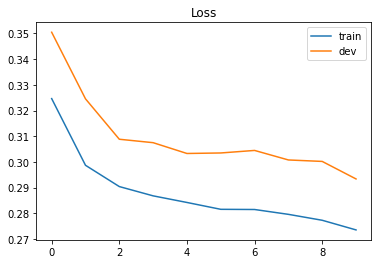

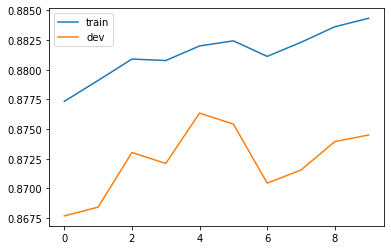

In [32]:
import matplotlib.pyplot as plt

# loss
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()


# accuracy
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

## 测试数据

In [33]:
# 预测测试标签
predictions = predict(X_test, w, b)
with open(output_path.format('logistic'), 'w') as f:
  f.write('id,label\n')
  for i, label in enumerate(predictions):
    f.write('{},{}\n'.format(i, label))

idx = np.argsort(np.abs(w))[::-1] # 返回最重要的权重
with open(X_test_path) as f:
  content = f.readline().strip('\n').split(',')

features = np.array(content)
for i in idx[0:10]:
  print(features[i], w[i])

 Other relative of householder -4.561848776920034
 Other Rel <18 never married RP of subfamily -1.484852765286571
 MSA to MSA 1.4753166329255802
 Michigan -1.3231988152499776
 Other Rel <18 ever marr RP of subfamily -1.2210725022496605
 Unemployed full-time 1.1815273183560095
 12th grade no diploma -1.1121985054286616
 South Korea 1.025721005594475
 California -0.9688433257300532
 South Korea -0.9655947401043382


# 生成模型
生成模型是利用概率模型对结果结果分类计算。因为其可能解析出最优解，故分数据集的时候，不需要分割development set来不断优化结果。

In [0]:
with open(X_train_path) as f:
    next(f) # 返回下一行，因为有标题信息，故需要先next下一行
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_path) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_path) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


X_train, X_mean, X_std = normalization(X_train)
X_test, _, _ = normalization(X_test, False, X_mean, X_std)

生成器模型需要计算源数据的均值和方差

In [0]:
# 二分类问题，故需要计算两个类别的均值
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis=0)
mean_1 = np.mean(X_train_1, axis=0)

cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

mean: $\mu=\frac{1}{N}\sum_{n=1}^{N}x^n$

cov: $\Sigma=\frac{1}{N}\sum_{n=1}^{N}(x^n-\mu)(x^n-\mu)^T$

In [0]:
for x in X_train_0:
  cov_0 += np.dot(np.transpose([x - mean_0]), [x-mean_0]) / X_train_0.shape[0]

for x in X_train_1:
  cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[1]

# 共享协方差
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[1])

$z=(\mu^1-\mu^2)^T\Sigma^{-1}x - \frac{1}{2}(\mu^1)^T\Sigma^{-1}\mu^1+\frac{1}{2}(\mu^2)^T\Sigma^{-1}\mu^2+ln\frac{N_{1}}{N_{2}}$

$w = (\mu^1-\mu^2)^T\Sigma^{-1}$

$b = - \frac{1}{2}(\mu^1)^T\Sigma^{-1}\mu^1+\frac{1}{2}(\mu^2)^T\Sigma^{-1}\mu^2+ln\frac{N_{1}}{N_{2}}$

In [0]:
# 求协方差矩阵的逆
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# 计算权重和偏移量
w = np.dot(inv, mean_0 - mean_1)
b = (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1)) + np.log(float(X_train_0.shape[0] / X_train_1.shape[0]))

In [20]:
# 计算精度
Y_train_pred = 1 - predict(X_train, w, b)
print('Training accuracy: {}'.format(accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.794732379828959


## 用生成器模型测试数据

In [22]:
predictions = 1 - predict(X_test, w, b)
with open(output_path.format('generative'), 'w') as f:
  f.write('id, label\n')
  for i, label in enumerate(predictions):
    f.write('{},{}\n'.format(i, label))

ind = np.argsort(np.abs(w))[::-1]
with open(X_test_path) as f:
  content = f.readline().strip('\n').split(',')

features = np.array(content)
for i in ind[0:10]:
  print(features[i], w[i])

 3 4.873046875
weeks worked in year -4.726806640625
 0 -4.48486328125
 1 -4.13330078125
 40 -3.3807373046875
 Retail trade -3.258544921875
 94 3.12939453125
 31 2.831298828125
 Abroad -2.61279296875
 19 -2.578125
